# 0. INITIAL DATA

## ОПИСАНИЕ КЕЙСА
Мы работаем в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

## ЗАДАЧА
Создать работоспособную модель

## МЕТРИКА
MAPE

In [309]:
# Libraries import

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import scalers and encoders
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif

# model building libraries
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# other libraries
import geopy.distance
import re
# from wordcloud import WordCloud

# crispy data display module
from termcolor import colored

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# зафиксируем RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

#setting max_columns to be able to see whole spreadsheet
pd.set_option('display.max_columns', None)

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip3 freeze > requirements.txt

In [176]:
# Подгрузим наши данные из соревнования

# DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [177]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [178]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097


In [179]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [180]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like u...,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice siz...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443


In [181]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [182]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [183]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

/var/folders/c5/w191_qyn6h5cz3wl_4__rjxw0000gn/T/ipykernel_13400/447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [185]:
# display number of unique values
data.nunique()

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
sample                                             2
reviewer_score                                    38
dtype: int64

# 1. FEATURE ENGINEERING
## Hotel related features:
- *hotel_address*
- *hotel_name*
- *lat* / *lng* - coordinates
- *total_number_of_reviews*
- *additional_number_of_scoring* - only scores, without text reviews or comments

### Hotel name

In [186]:
# Explore hotel names / addresses
# Find the hotels with one name but different or missing addresses
grouped_data = data[['hotel_address', 'hotel_name']].groupby('hotel_name').nunique()
not_alone_hotels = grouped_data[grouped_data['hotel_address'] != 1].index.tolist()
# only 1 hotel found - Hotel Regina (3 pcs.)
# let's add the city to the name
mask = data['hotel_name'].isin(not_alone_hotels)
print(colored('Repeated hotels:', 'green'))
display(data[mask][['hotel_name', 'hotel_address']].value_counts().reset_index())

Repeated hotels:


,hotel_name,hotel_address,0
0,Hotel Regina,Bergara 2 4 Eixample 08002 Barcelona Spain,590
1,Hotel Regina,Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria,284
2,Hotel Regina,Via Cesare Correnti 13 Milan City Center 20123 Milan Italy,60


In [187]:

data['hotel_name'] = data.apply(lambda row: row['hotel_name']+' '+row['hotel_address'].split()[-2] 
                                                                  if row['hotel_name'] in not_alone_hotels 
                                                                  else row['hotel_name'], axis=1)
mask = data['hotel_name'].str.contains(not_alone_hotels[0])
print(colored('Update repeated hotel names: ', 'green'))
data[mask]['hotel_name'].value_counts()

Update repeated hotel names: 


Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

Model cannot use names of the hotels directly - they required to be encoded

In [188]:
# let's select best hotel with > 100 scores and average score > 100

hotels_list = data.groupby('hotel_name')['average_score'].agg(['mean', 'count'])
mask = (hotels_list['mean'] >= 9) & (hotels_list['count'] >= 100)
top_hotels = hotels_list[mask]
print(colored('Top hotels (more than 9.0 average score, more than 100 scores):', 'green'))
display(top_hotels)


Top hotels (more than 9.0 average score, more than 100 scores):


,mean,count
hotel_name,,
41,9.6,103
Acad mie H tel Saint Germain,9.0,255
Alma Barcelona GL,9.2,179
Amba Hotel Charing Cross,9.3,785
Ambassade Hotel,9.3,551
...,...,...
Waldorf Astoria Amsterdam,9.5,142
art otel Amsterdam,9.0,790
citizenM London Bankside,9.1,1517


In [189]:
# we will leave only these hotels names, other will be shown as 'other'
data['hotel_cat'] = data['hotel_name'].apply(lambda s: s if s in top_hotels.index else 'other')

#encoding hotel names
ord_encoder = ce.OrdinalEncoder()
hotels_enc = ord_encoder.fit_transform(data['hotel_cat'])
data.drop('hotel_cat', axis=1, inplace=True)
data = pd.concat([data, hotels_enc], axis=1)
data = data.rename(columns={'hotel_cat': 'hotel_code'})
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_code
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like u...,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice siz...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102,0,0.0,1
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443,0,0.0,1
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393192,2.161520,0,0.0,1
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hotel has been revamped and what a surprise Love every second of it inclu...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']",656 day,45.479888,9.196298,0,0.0,2
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobi...",444 day,52.370545,4.888644,0,0.0,3


### Hotel address

In [190]:
addresses = pd.Series(data['hotel_address'].unique())
# We can easily extract countries and cities from the address line
# Only one country with 2 words - UK requires some specifics
countries = addresses.apply(lambda s: s.split()[-1] 
                            if s.split()[-1] != 'Kingdom'
                            else ' '.join(s.split()[-2:]))
print(colored('Available countries: ', 'green'))
display(countries.value_counts())

# Extraciting cities - UK again requires some specifics
cities = addresses.apply(lambda s: s.split()[-2]
                       if s.split()[-1] != 'Kingdom'
                       else s.split()[-5])
print(colored('Available cities: ', 'green'))
display(cities.value_counts())

# Combine all in one DataFrame
addresses = pd.DataFrame({
    'address': addresses,
    'country': countries,
    'city': cities})
print(colored('In our data we have only one city from each country:', 'green'))
display(addresses.groupby(['country', 'city']).count())

Available countries: 


France            458
United Kingdom    399
Spain             211
Italy             162
Austria           158
Netherlands       105
dtype: int64

Available cities: 


Paris        458
London       399
Barcelona    211
Milan        162
Vienna       158
Amsterdam    105
dtype: int64

In our data we have only one city from each country:


,,address
country,city,
Austria,Vienna,158
France,Paris,458
Italy,Milan,162
Netherlands,Amsterdam,105
Spain,Barcelona,211
United Kingdom,London,399


In [191]:
# Let's add to the dataset only country - not worth to add city
data['hotel_country'] = data['hotel_address'].apply(lambda s: s.split()[-1] 
                            if s.split()[-1] != 'Kingdom'
                            else ' '.join(s.split()[-2:]))
print(colored('Hotel countries before encoding:', 'green'))
display(data['hotel_country'].value_counts())


Hotel countries before encoding:


United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [193]:
# Extract the zip codes
pd.set_option('max_colwidth', 120)
print(colored("Let's see zip code allocation for each country:", 'green'))
display(addresses.groupby('country')['address'].agg(pd.Series.mode))
zip_position = {'Austria': -3,  
                'France': -3,
                'Italy': -3,
                'Netherlands': -4,
                'Spain': -3,
                'United Kingdom': -4
}
addresses['zip_code'] = addresses.apply(lambda row: row['address'].split()[zip_position[row['country']]], axis=1)
data['zip_code'] = data.apply(lambda row: row['hotel_address'].split()[zip_position[row['hotel_country']]][:-1]
                              if row['hotel_country'] == 'United Kingdom' 
                              and row['hotel_address'].split()[zip_position[row['hotel_country']]][-1].isalpha()
                              else row['hotel_address'].split()[zip_position[row['hotel_country']]], axis=1)

data.head(2)

Let's see zip code allocation for each country:


country
Austria           [Althanstra e 5 09 Alsergrund 1090 Vienna Austria, Am Heumarkt 35 37 03 Landstra e 1030 Vienna Austria, Am Hof 2 01 ...
France            [1 3 Rue d Argentine 16th arr 75116 Paris France, 1 5 Passage Ruelle 18th arr 75018 Paris France, 1 Avenue Carnot 17...
Italy             [6 Via Aristotile Fioravanti Garibaldi Station 20154 Milan Italy, Alzaia Naviglio Grande 8 Navigli 20144 Milan Italy...
Netherlands       [ s Gravesandestraat 55 Oost 1092 AA Amsterdam Netherlands, 2e Hugo de Grootstraat 2 6 Westerpark 1052 LC Amsterdam ...
Spain             [234 Diputacio Eixample 08007 Barcelona Spain, 277 Carrer de Proven a Eixample 08037 Barcelona Spain, Ample 1 Pla a ...
United Kingdom    [1 15 Templeton Place Earl s Court Kensington and Chelsea London SW5 9NB United Kingdom, 1 2 Serjeant s Inn Fleet St...
Name: address, dtype: object

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_code,hotel_country,zip_code
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like u...,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice siz...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102,0,0.0,1,Italy,20161
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443,0,0.0,1,Netherlands,1043


In [194]:
districts = pd.read_csv(DATA_DIR+'districts.csv')
districts.head()

,Unnamed: 0,PostCode,Type of District
0,0,1010,History Center
1,1,1015,History Center
2,2,1020,Center
3,3,1030,Center
4,4,1040,Center


In [195]:
# Reading data with zip codes to type of district allocation
districts['PostCode'] = districts['PostCode'].apply(lambda x: str(x))
districts = districts.set_index('PostCode')['Type of District']
districts_dict = districts.to_dict()
districts_dict


{'1010': 'History Center',
 '1015': 'Center',
 '1020': 'Center',
 '1030': 'Center',
 '1040': 'Center',
 '1050': 'Center',
 '1060': 'Center',
 '1070': 'Center',
 '1080': 'Center',
 '1090': 'Other',
 '1100': 'Other',
 '1110': 'Other',
 '1120': 'Other',
 '1130': 'Other',
 '1140': 'Other',
 '1150': 'Other',
 '1160': 'Other',
 '1170': 'Other',
 '1180': 'Other',
 '1190': 'Other',
 '1200': 'Other',
 '1210': 'Other',
 '1220': 'Other',
 '1230': 'Other',
 '75001': 'History Center',
 '75002': 'Center',
 '75003': 'Center',
 '75004': 'Center',
 '75005': 'Center',
 '75006': 'Center',
 '75007': 'Center',
 '75008': 'Center',
 '75009': 'Center',
 '75010': 'Other',
 '75011': 'Center',
 '75012': 'Other',
 '75013': 'Other',
 '75014': 'Other',
 '75015': 'Other',
 '75016': 'Other',
 '75017': 'Other',
 '75018': 'Other',
 '75019': 'Other',
 '75020': 'Other',
 '75116': 'Other',
 '92120': 'Suburb',
 '92170': 'Suburb',
 '20121': 'History Center',
 '20122': 'History Center',
 '20123': 'History Center',
 '20124': 

In [196]:
data['district'] = data['zip_code'].apply(lambda x: districts_dict[x])
data['district'].value_counts()

Center            237405
Other             191256
History Center     85010
Suburb              2067
Name: district, dtype: int64

In [197]:
# Encoding country and district data
data['hotel_country_code'] = data['hotel_country'].astype('category').cat.codes
print(colored('Hotel countries after encoding:', 'green'))
display(data['hotel_country_code'].value_counts())

data['district_code'] = data['district'].astype('category').cat.codes
# Make district codes unique
def make_unique_district_code(country_code, district_code):
    result = country_code + district_code * 6
    return result
data['district_code'] = data.apply(
    lambda raw: make_unique_district_code(raw['hotel_country_code'], raw['district_code']), axis=1)
print(colored('Districts after encoding:', 'green'))
display(data['district_code'].value_counts())

Hotel countries after encoding:


5    262301
4     60149
1     59928
3     57214
0     38939
2     37207
Name: hotel_country_code, dtype: int64

Districts after encoding:


5     134161
17    103832
1      31295
15     29035
4      25194
11     23517
13     23044
16     18602
0      18007
2      16892
10     16228
9      15222
6      12440
8      12064
3      11856
12      8492
14      8251
7       5539
21      1101
23       791
22       125
19        50
Name: district_code, dtype: int64

In [198]:
pivot_score = pd.pivot_table(
    data,
    index='zip_code',
    values='average_score',
    aggfunc='mean'
)
pivot_score = pivot_score.reindex(
    pivot_score['average_score'].sort_values(ascending=False).index
)

# Scale the scores
mm_scaler = MinMaxScaler()
scaler_data = pivot_score.values
score_scaled = mm_scaler.fit_transform(scaler_data)
pivot_score['district_rating'] = score_scaled
data['district_rating'] = data['zip_code'].apply(lambda x: pivot_score['district_rating'][x])
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_code,hotel_country,zip_code,district,hotel_country_code,district_code,district_rating
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like u...,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice siz...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102,0,0.0,1,Italy,20161,Other,2,14,0.501770
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443,0,0.0,1,Netherlands,1043,Other,3,15,0.694642
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393192,2.161520,0,0.0,1,Spain,08008,Center,4,4,0.782434
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hotel has been revamped and what a surprise Love every second of it inclu...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']",656 day,45.479888,9.196298,0,0.0,2,Italy,20124,Center,2,2,0.697235
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobi...",444 day,52.370545,4.888644,0,0.0,3,Netherlands,1012,History Center,3,9,0.674806


### Visualise the dependence of the district and target - review score

(7.0, 10.0)

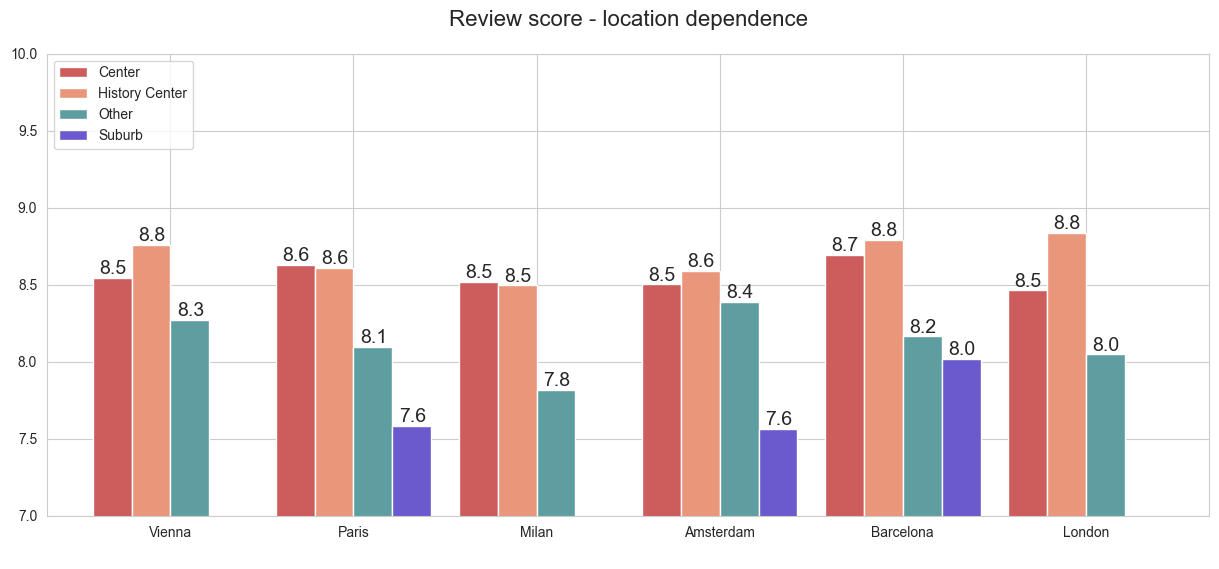

In [199]:
# extract only the train data
pivot_district_type = data[data['sample'] == 1].groupby(
    ['hotel_country', 'district'])['reviewer_score'].mean().unstack()
#adding cities
country_city = addresses.groupby(['country','city']).count().reset_index()
pivot_district_type = pivot_district_type.merge(
    right=country_city[['country', 'city']],
    left_on='hotel_country',
    right_on='country',
    how='left'
)

fig1, ax1 = plt.subplots(figsize=(15,6))
sns.set_style('whitegrid')
district_type_plot = pivot_district_type.plot(
    kind='bar',
    ax=ax1,
    label='city',
    width=0.85,
    color=['indianred', 'darksalmon', 'cadetblue', 'slateblue'],
    rot=0
)
ax1.set_title('Review score - location dependence', size=16, pad=20)
ax1.set_xlabel(' ')
ax1.set_xticklabels(pivot_district_type['city'])
ax1.legend(loc='upper left')
#adding annotations
for p in district_type_plot.patches:
    district_type_plot.annotate(
        '{:.1f}'.format(p.get_height()), (p.get_x()+0.11, p.get_height()),
        ha='center', va='bottom', fontsize=14)

plt.ylim((7, 10))

### Hotel coordinates ('lat', 'lng)
We will use these features to get the distance from center of the city to the hotel

In [200]:
# some hotels do not have coordinates
# calculate average coordinates for each district

pivot_coord = pd.pivot_table(
    data,
    index='zip_code',
    values=['lat', 'lng'],
    dropna=True,
    aggfunc='mean'
)
data['lat'] = data.apply(lambda row: pivot_coord['lat'][row['zip_code']]
                        if np.isnan(row['lat'])
                        else row['lat'], axis=1)
data['lng'] = data.apply(lambda row: pivot_coord['lng'][row['zip_code']]
                        if np.isnan(row['lng'])
                        else row['lng'], axis=1)

In [201]:
# We have limited number of cities - let's collect the city centers coordinates
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ], columns = ['country', 'city','center_lat', 'center_lng']
).set_index('country')

def get_dist_to_center(country, lat, lng):
    lat_center = centers['center_lat'][country]
    lng_center = centers['center_lng'][country]
    
    return geopy.distance.geodesic([lng_center, lat_center], [lng, lat]).km

# geopy.distance works very slow - let's apply it only to the unique hotel names instead of whole data set
hotels_unique = data[['hotel_name', 'hotel_country', 'lat', 'lng']].drop_duplicates()
hotels_unique['hotel_distance_to_center'] = hotels_unique.apply(
    lambda row: get_dist_to_center(row['hotel_country'], row['lat'], row['lng']), axis=1)
hotels_unique.drop(['hotel_country', 'lat', 'lng'], axis=1, inplace=True)
data = data.merge(
    hotels_unique,
    how='left',
    on='hotel_name',
    sort=False
)
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_code,hotel_country,zip_code,district,hotel_country_code,district_code,district_rating,hotel_distance_to_center
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like u...,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice siz...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102,0,0.0,1,Italy,20161,Other,2,14,0.501770,7.837768
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443,0,0.0,1,Netherlands,1043,Other,3,15,0.694642,6.243807
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393192,2.161520,0,0.0,1,Spain,08008,Center,4,4,0.782434,0.563942
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hotel has been revamped and what a surprise Love every second of it inclu...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']",656 day,45.479888,9.196298,0,0.0,2,Italy,20124,Center,2,2,0.697235,1.873428
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobi...",444 day,52.370545,4.888644,0,0.0,3,Netherlands,1012,History Center,3,9,0.674806,0.403517


In [202]:
# we may drop the coordinates
data.drop(['lat', 'lng'], axis=1, inplace=True)

## Average score / Additional number of scoring
Practically, nothing to do. Good score as it is

## Total number of reviews
Let's identify new hotels which have good score (> 9) but low number of review (<1000)

In [203]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,hotel_code,hotel_country,zip_code,district,hotel_country_code,district_code,district_rating,hotel_distance_to_center
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like u...,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice siz...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,0,0.0,1,Italy,20161,Other,2,14,0.501770,7.837768
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,0,0.0,1,Netherlands,1043,Other,3,15,0.694642,6.243807
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,0,0.0,1,Spain,08008,Center,4,4,0.782434,0.563942
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hotel has been revamped and what a surprise Love every second of it inclu...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']",656 day,0,0.0,2,Italy,20124,Center,2,2,0.697235,1.873428
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobi...",444 day,0,0.0,3,Netherlands,1012,History Center,3,9,0.674806,0.403517


In [204]:
hotels_list = data.groupby('hotel_name')['average_score'].agg(['mean', 'count'])
mask = (hotels_list['count'] <= 1000) & (hotels_list['mean'] >= 9)
new_hotels = hotels_list[mask].index
data['new_hotel'] = data['hotel_name'].apply(
    lambda s: 1 if s in new_hotels else 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## USER DATA FEATURES
- reviewer_nationality
- tags
- total_number_of_reviews_reviewer_has_given

## Reviewer nationality
Let's dip dive and expend the feature information

In [205]:
# Check the most popular reviewers' countries
data.reviewer_nationality = data.reviewer_nationality.apply(lambda s: s.strip())
nationality_count = data.reviewer_nationality.nunique()
print(colored(f'Representatives of {nationality_count} countries made reviews', 'green'))
print(colored('The most popular countries:', 'green'))
display(data['reviewer_nationality'].value_counts(ascending=False)[:40].index)

# Check English-speaking countries
english_list = ['United Kingdom', 
                'United States of America', 
                'Australia', 
                'Canada', 
                'New Zealand']
data['reviewer_en'] = data['reviewer_nationality'].apply(
    lambda s: 1 if s in english_list else 0)

# Check middle-east countries
me_list = ['United Arab Emirates', 
               'Saudi Arabia', 
               'Turkey', 
               'Kuwait', 
               'Qatar', 
               'Oman']
data['reviewer_me'] = data['reviewer_nationality'].apply(
    lambda s: 1 if s in me_list else 0)

# check country residence
data['reviewer_resident'] = data.apply(
    lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)

# encoding nationality
data['reviewer_nationality_cat'] = data['reviewer_nationality'].astype('category').cat.codes

Representatives of 227 countries made reviews
The most popular countries:


Index(['United Kingdom', 'United States of America', 'Australia', 'Ireland',
       'United Arab Emirates', 'Saudi Arabia', 'Netherlands', 'Switzerland',
       'Germany', 'Canada', 'France', 'Israel', 'Italy', 'Belgium', 'Turkey',
       'Kuwait', 'Spain', 'Romania', 'Russia', 'South Africa', 'India',
       'Greece', 'China', 'Sweden', 'New Zealand', 'Singapore', 'Hong Kong',
       'Poland', 'Qatar', 'Austria', 'Egypt', 'Norway', 'Czech Republic',
       'Lebanon', 'Hungary', 'Malaysia', 'Thailand', 'Brazil', 'Portugal',
       'Finland'],
      dtype='object')

### Visualise the influence of residence to target review score

(7.0, 9.5)

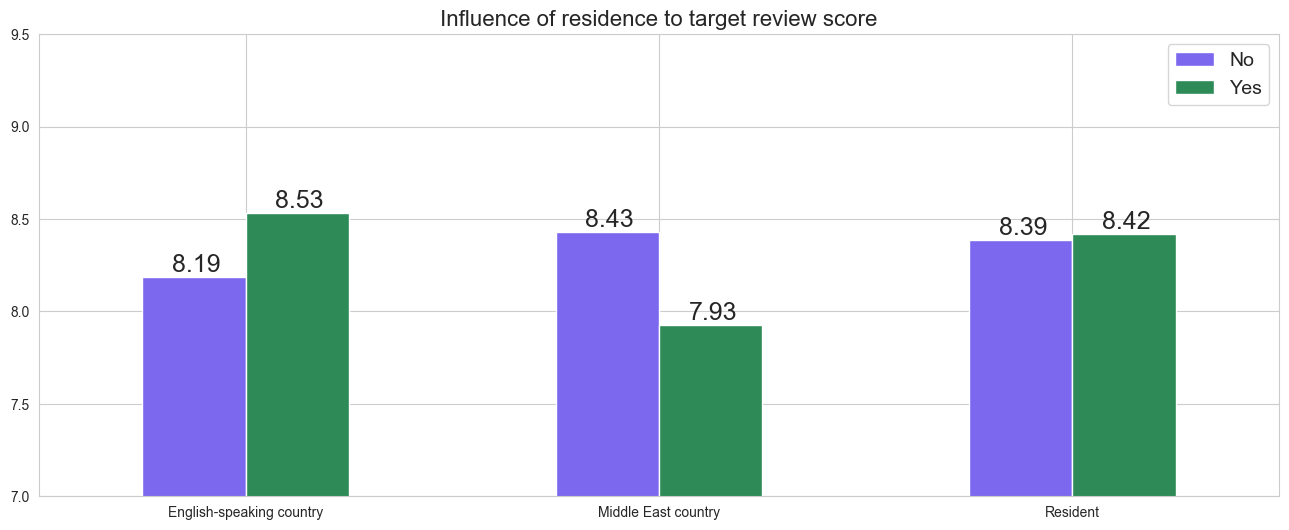

In [206]:
# we need to use only train data
mask = data['sample'] == 1
pivot_en = data[mask].groupby('reviewer_en')['reviewer_score'].mean()
pivot_me = data[mask].groupby('reviewer_me')['reviewer_score'].mean()
pivot_resident = data[mask].groupby('reviewer_resident')['reviewer_score'].mean()

# combine data
pivot = pd.DataFrame({
    'English-speaking country': pivot_en,
    'Middle East country': pivot_me,
    'Resident': pivot_resident
}).T

# making plot
fig2, ax2 = plt.subplots(figsize=(16, 6))
pivot_barplot = pivot.plot(
    kind='bar',
    ax=ax2,
    color=['mediumslateblue', 'seagreen'],
    rot=0
)
ax2.set_title('Influence of residence to target review score', size=16)
ax2.legend(['No', 'Yes'], loc='upper right', fontsize=14)

for p in pivot_barplot.patches:
    pivot_barplot.annotate(
        '{:.2f}'.format(p.get_height()),
        (p.get_x()+0.13, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=18
    )

plt.ylim(7, 9.5)

## Tags
Let's explore which tags do we have and what to do with them

In [207]:
data.tags.head()

0                                                       [' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']
1                                                         [' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']
2              [' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']
3                                            [' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']
4    [' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobi...
Name: tags, dtype: object

In [208]:
# function to unpack the tags to the list from tags string

def get_tags(tag_string):
    tag_list = tag_string[2:-2].split(" ', ' ")
    tag_list = [s.strip() for s in tag_list]
    return tag_list

data['tag_list'] = data['tags'].apply(get_tags)
data['tag_num'] = data['tag_list'].apply(len)
print(colored(f'Max number of tags in one review: {data.tag_num.max()}', 'green'))

Max number of tags in one review: 6


In [209]:
data['tag_list']

0                                                                 [Leisure trip, Couple, Double Room, Stayed 2 nights]
1                                                                   [Leisure trip, Group, Triple Room, Stayed 1 night]
2                            [Business trip, Solo traveler, Twin Room, Stayed 1 night, Submitted from a mobile device]
3                                                      [Leisure trip, Couple, Ambassador Junior Suite, Stayed 1 night]
4         [Business trip, Solo traveler, Classic Double or Twin Room, Stayed 2 nights, Submitted from a mobile device]
                                                              ...                                                     
515733                [Leisure trip, Group, Club Double or Twin Room, Stayed 2 nights, Submitted from a mobile device]
515734                   [Leisure trip, Couple, Standard Double Room, Stayed 4 nights, Submitted from a mobile device]
515735                                          

In [210]:
# let's group the tags by type
def get_tags_type(tag_list):
    reviewer_types = {'Solo traveler': 1,
                      'Couple': 2,
                      'Travelers with friends': 3,
                      'Family with young children': 4,
                      'Family with older children': 5,
                      'Group': 6}
    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 1 #leisure by default
    tag_business_trip = 0
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_room_type = ''
    tag_list = tag_list.copy()
    for tag in list(tag_list):
        if tag == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tag_list.remove(tag)
        if tag == 'With a pet':
            tag_with_pet = 1
            tag_list.remove(tag)
        if tag == 'Business trip':
            tag_leisure_trip = 0
            tag_list.remove(tag)
        if tag == 'Leisure trip':
            tag_list.remove(tag)
        if tag in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[tag]
            tag_list.remove(tag)
        if re.fullmatch(r'Stayed\s\d+\snight\w?', tag):
            tag_count_nights = int(tag.split()[-2])
            tag_list.remove(tag)
        
    if len(tag_list) > 0:
        tag_room_type = tag_list[0]
            
    return tag_from_mobile, tag_with_pet, tag_leisure_trip, \
        tag_reviewer_type, tag_count_nights, tag_room_type
    
data[['tag_from_mobile',
        'tag_with_pet',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
] = pd.DataFrame(data['tag_list'].apply(get_tags_type).tolist(),
                 index=data.index)
print(colored('Number of unique values in all tag categories: ', 'green'))
display(data[['tag_from_mobile',
        'tag_with_pet',
        'tag_leisure_trip',
        'tag_reviewer_type',
        'tag_count_nights',
        'tag_room_type']
].nunique())
        
# optimize type for diagramm
data['tag_count_nights'] = data['tag_count_nights'].astype('int8')

Number of unique values in all tag categories: 


tag_from_mobile         2
tag_with_pet            2
tag_leisure_trip        2
tag_reviewer_type       6
tag_count_nights       32
tag_room_type        2388
dtype: int64

In [211]:
# We need to aggregate room types
# First, rooms with the view
data['tag_view_room'] = data['tag_room_type'].apply(
    lambda s: 1 if ('View' in s) | ('Panoramic' in s) else 0)

# detect proper categories
def get_room_type(tag):
    room_types = ['without Window', 'Guestroom', 'Classic', 'Single', 
                  'Standard', 'Superior', 'Comfort', 'Club', 'Suite', 
                  'Deluxe', 'King', 'Premier']
    
    for rt in room_types:
        if rt in tag:
            return rt
    
    if 'Double' in tag or 'Twin' in tag:
        return 'Double'
    
    return 'other'

data['room_type'] = data['tag_room_type'].apply(get_room_type)

print(colored(f'Now we have: {data.room_type.nunique()} room types', 'green'))

Now we have: 14 room types


In [212]:
# encoding room types
encoder_t = ce.OneHotEncoder(cols='tag_reviewer_type', use_cat_names=True)
tag_type_bin = encoder_t.fit_transform(data['tag_reviewer_type'])
data = pd.concat([data, tag_type_bin], axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [213]:
encoder_r = ce.OneHotEncoder(cols='room_type', use_cat_names=True)
room_type_bin = encoder_r.fit_transform(data['room_type'])
data = pd.concat([data, room_type_bin], axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


### Visualisation of dependance between night reviewer've been in the hotel and target review score 

<AxesSubplot: xlabel='tag_count_nights', ylabel="('count', 'reviewer_score')">

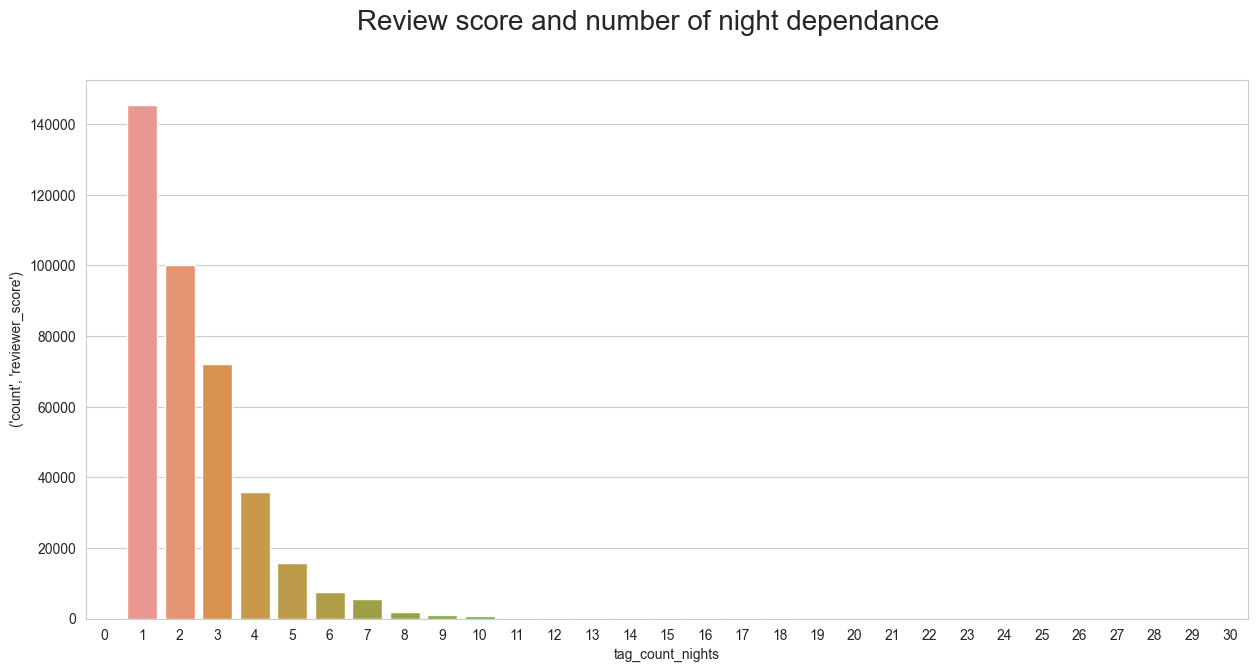

In [214]:
pivot_nights = pd.pivot_table(
    data[data['sample'] == 1],
    index='tag_count_nights',
    values='reviewer_score',
    aggfunc=['count', 'mean'])

fig3, ax3 = plt.subplots(figsize=(15, 7))
plt.suptitle('Review score and number of night dependance', fontsize=20)
sns.barplot(
    x=pivot_nights.index,
    y=pivot_nights[('count', 'reviewer_score')]
)

Most of the trips are quite short as it should be for city hotels.
Some reviews containts 0 nights to stay - it might be cancelled trips.

### Visualisation of dependance between room category and target review score

(7.0, 9.3)

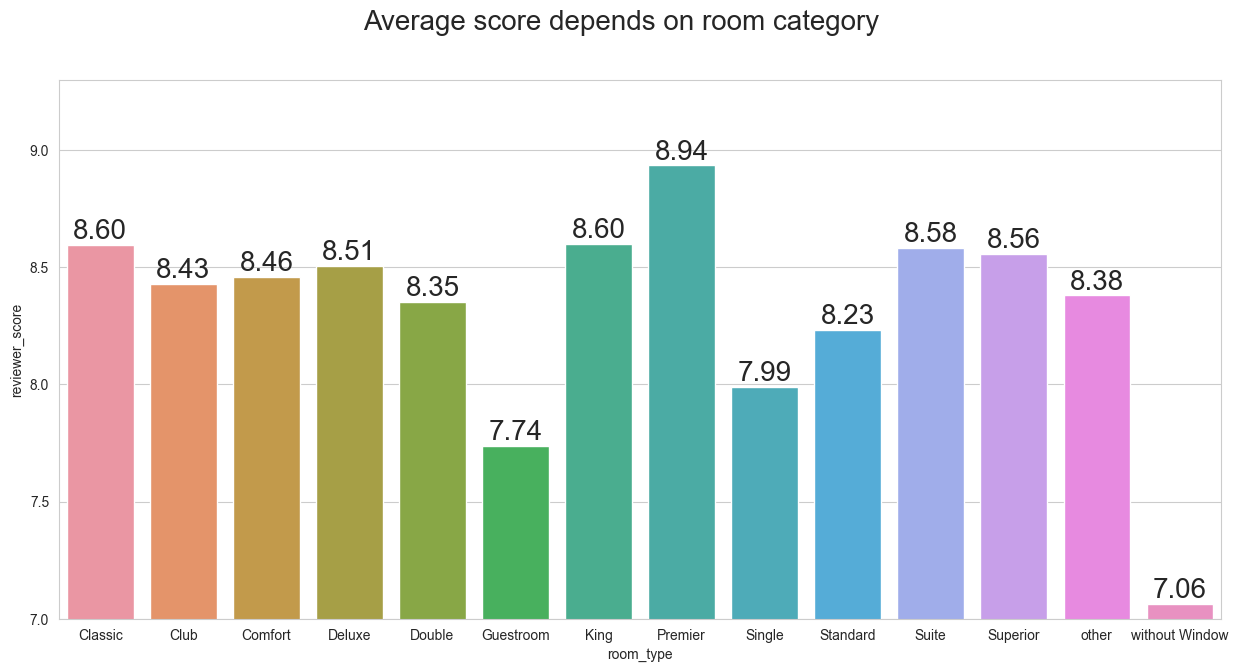

In [215]:
pivot_types = pd.pivot_table(
    data[data['sample'] == 1],
    index='room_type',
    values='reviewer_score',
    aggfunc='mean')

fig4, ax4 = plt.subplots(figsize=(15,7))
plt.suptitle('Average score depends on room category', size=20)
bar_types = sns.barplot(x=pivot_types.index, y=pivot_types['reviewer_score'])
for p in bar_types.patches:
    bar_types.annotate(
        '{:.2f}'.format(p.get_height()),
        (p.get_x()+0.4, p.get_height()),
        ha='center', va='bottom', fontsize=20)
plt.ylim(7, 9.3)

In [216]:
# drop some columns
data.drop(['tag_reviewer_type', 'room_type', 'tag_room_type', 'tag_num'], axis=1, inplace=True)

## Total number of reviews has given

In [217]:
print(colored("Let's see how reviewers are split into the groups by number of reviews given", 'green'))
display(data['total_number_of_reviews_reviewer_has_given'].groupby(
    pd.cut(data['total_number_of_reviews_reviewer_has_given'], np.arange(0, 360, 25))).count())
# log type of distribution - make log to adjust
data['total_number_of_reviews_reviewer_has_given'] = np.log(data['total_number_of_reviews_reviewer_has_given'])

Let's see how reviewers are split into the groups by number of reviews given


total_number_of_reviews_reviewer_has_given
(0, 25]       488425
(25, 50]       21640
(50, 75]        3914
(75, 100]       1149
(100, 125]       294
(125, 150]       144
(150, 175]       119
(175, 200]        21
(200, 225]        12
(225, 250]         8
(250, 275]         2
(275, 300]         4
(300, 325]         4
(325, 350]         1
Name: total_number_of_reviews_reviewer_has_given, dtype: int64

Most of reviewers gave less than 100 reviews

## Time/Date features

In [218]:
# assign datetime type
data['review_date'] = pd.to_datetime(data['review_date'])

# create new features
data['review_week'] = data['review_date'].apply(
    lambda x: x.isocalendar()[1])
data['review_month'] = data['review_date'].dt.month

### Visualize dependance between week and month and target score

(8.0, 8.7)

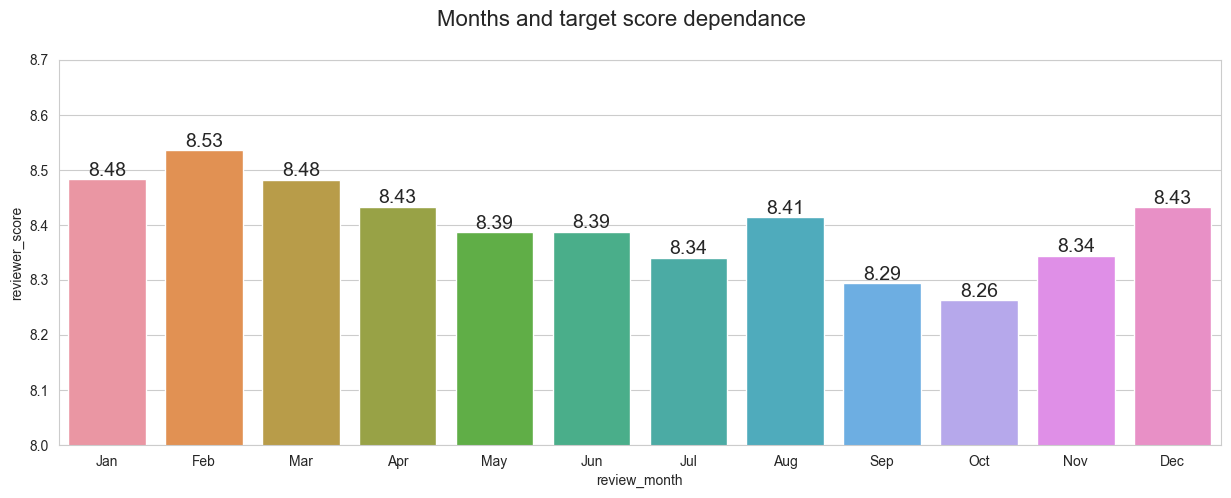

In [219]:
# use only train data
mask = data['sample'] == 1
pivot_month = data[mask][['review_month', 'reviewer_score']].groupby('review_month').mean()
fig5, ax5 = plt.subplots(figsize=(15, 5))
plt.suptitle('Months and target score dependance', size=16)
bar_month = sns.barplot(
    x=pivot_month.index,
    y=pivot_month.reviewer_score
)
ax5.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

for p in bar_month.patches:
    bar_month.annotate(
        '{:.2f}'.format(p.get_height()),
        (p.get_x()+0.4, p.get_height()),
        ha='center', va='bottom', fontsize=14)
plt.ylim(8, 8.7)


### Days since review
Nothing intersting here. Let's drop it out

In [220]:
data.drop('days_since_review', axis=1, inplace=True)

## Reviews

### Number of words in review
Let's analize dependance of the score and number of words in review.
There should be strong dependance because eg. if you like the hotel you probably write very short review, like 'everything was ok'. In the other hand in case the hotel service was very bad you will probably write longer review. 

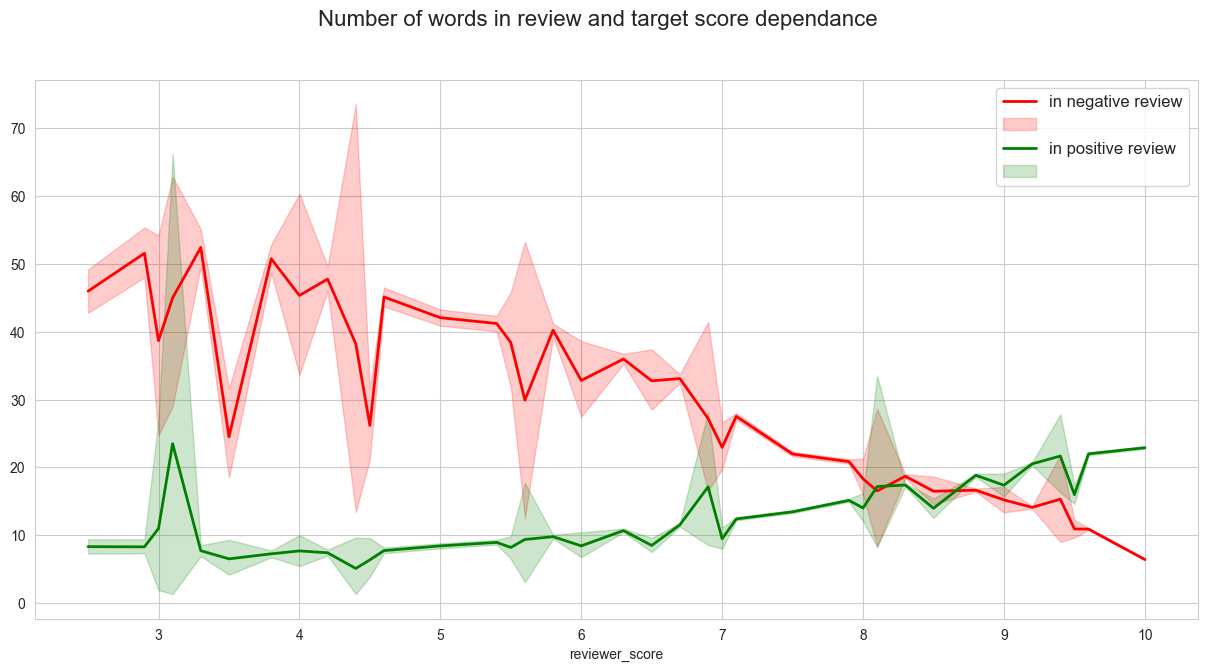

In [221]:
fig6, ax6 =plt.subplots(figsize=(15,7))
plt.suptitle('Number of words in review and target score dependance', size=16)
line_count_neg = sns.lineplot(
    data=data[mask],
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='red',
    linewidth=2
)
line_count_pos = sns.lineplot(
    data=data[mask],
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green',
    linewidth=2
)
ax6.set_ylabel('')
ax6.legend(['in negative review', '', 'in positive review', ''], loc='upper right', fontsize=12)


### Overall score distribution

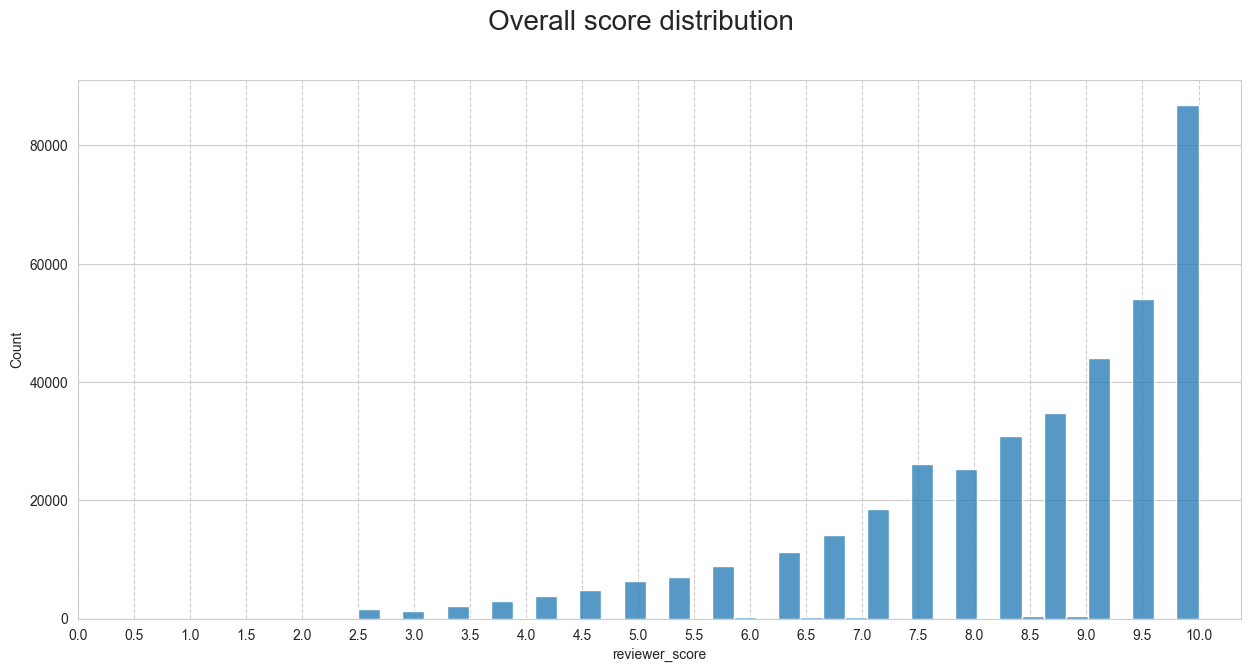

In [222]:
fig1, ax1 = plt.subplots(figsize=(15, 7))
plt.suptitle('Overall score distribution', size=20)
sns.histplot(
    ax=ax1,
    data=data[mask]['reviewer_score'],
    bins=len(data['reviewer_score'].value_counts())
).xaxis.grid(linestyle='--')
ax1.set_xticks(np.arange(0, 10.5, 0.5))

### Scaling review data

In [223]:
mm_scaler = MinMaxScaler()
# scaling positive reviews word counts
data['review_total_positive_word_counts_norm'] = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(data['review_total_positive_word_counts'])))

# scaling negative reviews word counts
data['review_total_negative_word_counts_norm'] = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(data['review_total_negative_word_counts'])))

# adding difference
data['review_total_word_counts_diff_norm'] = data['review_total_positive_word_counts_norm'] -\
    data['review_total_negative_word_counts_norm']

# adding positive vs negative flag
data['positive_words_more'] = data['review_total_word_counts_diff_norm'].apply(
    lambda x: 1 if x>=0 else 0)

In [224]:
# drop out unnecessary columns
data.drop(['review_total_positive_word_counts_norm', 'review_total_negative_word_counts_norm'], axis=1, inplace=True)

In [225]:
# calculate total positive/negative words propostion
data['review_total_word_counts'] = data['review_total_positive_word_counts'] + data['review_total_negative_word_counts']

# calculate positive/negative words propostion. If sum is zero considering 50:50 proportion
data['review_positive_word_proportion'] = data.apply(
    lambda row: 0.5 if row['review_total_word_counts'] == 0 
    else row['review_total_positive_word_counts'] / row['review_total_word_counts'], axis=1)


In [226]:
# drop unnecessary data
data.drop('review_total_word_counts', axis=1, inplace=True)

# 2. FEATURES SELECTION

In [227]:
data_copy = data.copy()

In [228]:
print(f'Currently we have {len(data_copy.columns)} features')
print('* including "sample" and target metrics')
print()
print('Dropping out DateTime and Object columns...')
data_copy = data_copy.select_dtypes(exclude=['datetime64[ns]', 'object'])
print(f'After drop we have {len(data_copy.columns)} features')
print('* including "sample" and target metrics')

Currently we have 59 features
* including "sample" and target metrics

Dropping out DateTime and Object columns...
After drop we have 48 features
* including "sample" and target metrics


In [232]:
# split num and cat columns
num_cols = [
    # word number features
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'review_total_word_counts_diff_norm', 'review_positive_word_proportion',
    # other
    'total_number_of_reviews_reviewer_has_given', 'tag_count_nights']

cat_cols = [
    # hotel features
    'additional_number_of_scoring', 'average_score', 'new_hotel',
    'total_number_of_reviews','hotel_code','hotel_country_code',
    'district_code','district_rating', 'hotel_distance_to_center',
    # trip/room features
    'tag_leisure_trip', 'tag_view_room', 'room_type_Double', 'room_type_other',
    'room_type_Suite', 'room_type_Classic', 'room_type_Standard', 'room_type_Superior',
    'room_type_Single', 'room_type_King', 'room_type_Deluxe', 'room_type_Club',
    'room_type_without Window', 'room_type_Premier', 'room_type_Comfort', 'room_type_Guestroom',
    # reviewer features
    'reviewer_en', 'reviewer_me', 'reviewer_resident', 'reviewer_nationality_cat',
    'tag_from_mobile', 'tag_with_pet', 'tag_reviewer_type_2.0', 'tag_reviewer_type_6.0',
    'tag_reviewer_type_1.0', 'tag_reviewer_type_4.0', 'tag_reviewer_type_5.0', 'tag_reviewer_type_3.0',
    # trip time
    'review_week', 'review_month',
    # review features
    'positive_words_more'] 

## Multicollinearity analisys - continious features

In [249]:

def show_corr_heatmap(cols_list, title, method='pearson', figsize=(6, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    corr = data[cols_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True,
                linewidths=0.1, 
                ax=ax,
                mask=mask,     
                cmap='viridis', 
                fmt='0.1g')
    ax.set_title(title, fontsize=14)
    plt.show()

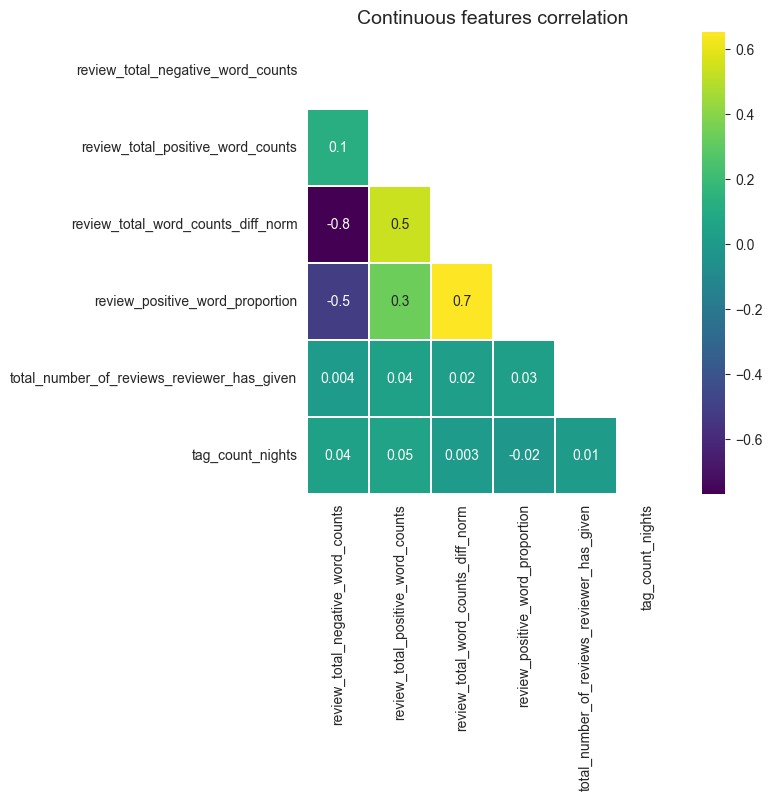

In [250]:
show_corr_heatmap(num_cols, 'Continuous features correlation')

Nothing to drop - theres is no multicollinearity (we do not count review_counts vs diff_review_word_counts)

## Multicollinearity analisys - categorical features

In [253]:
# split features in 2 categories: hotel/room and reviewer/trip time/review
cal_cols_p1 = cat_cols[:25]
cal_cols_p2 = cat_cols[25:]

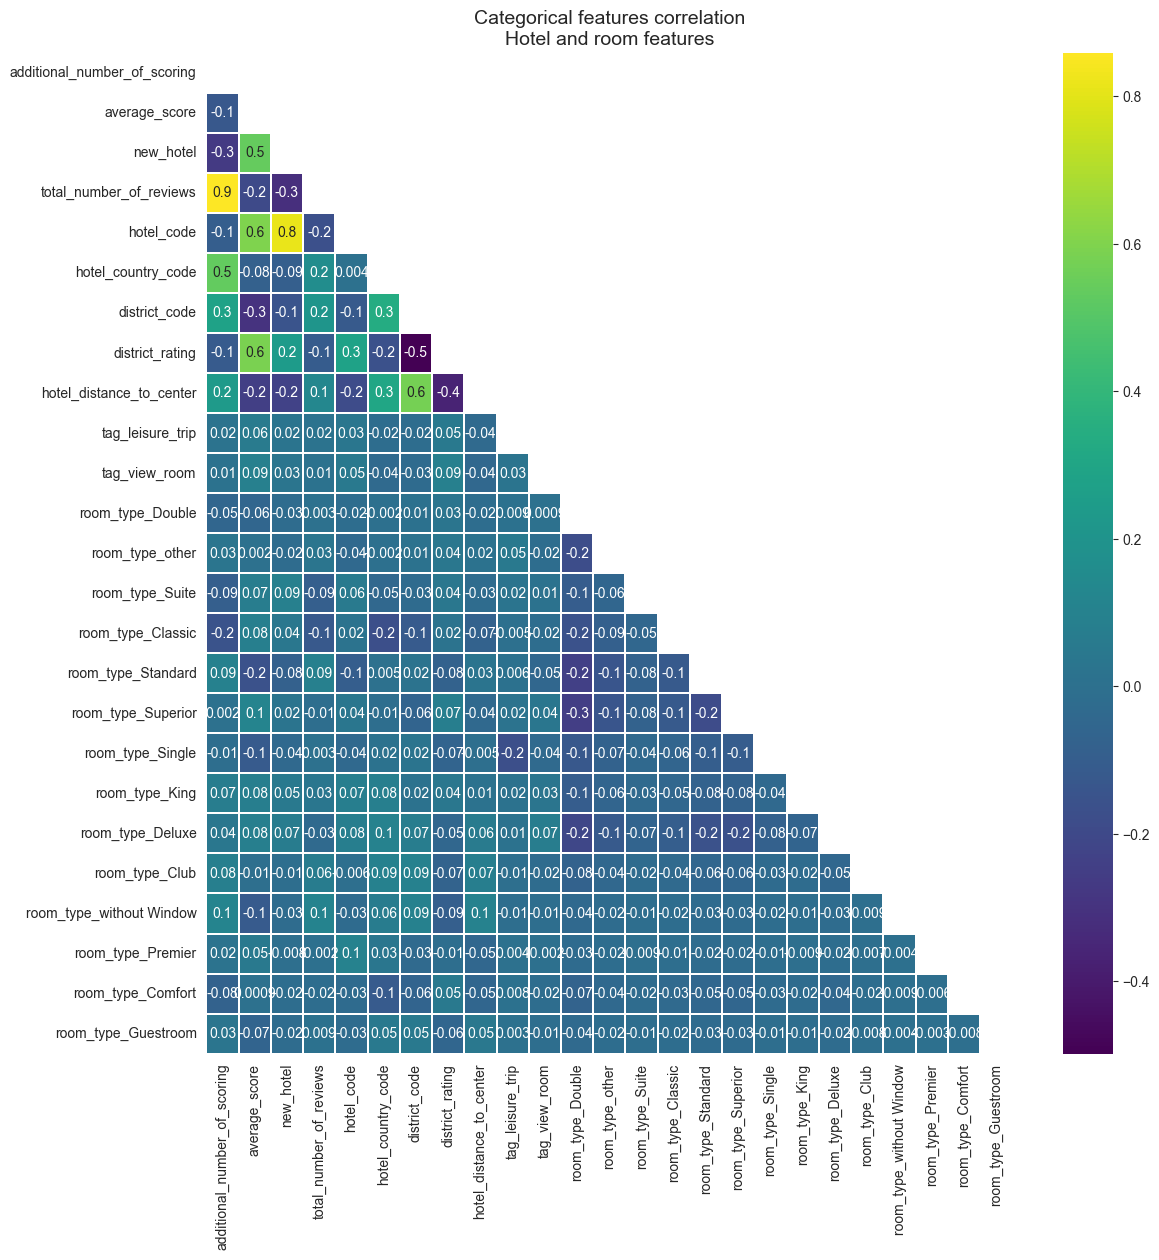

In [256]:
# drawing heatmap for cat 1
show_corr_heatmap(cal_cols_p1, 'Categorical features correlation\nHotel and room features',
                  method='spearman', figsize=(13, 13))

In [257]:
# adding some columns with big correlation to drop list
to_drop = ['additional_number_of_scoring', 'new_hotel']

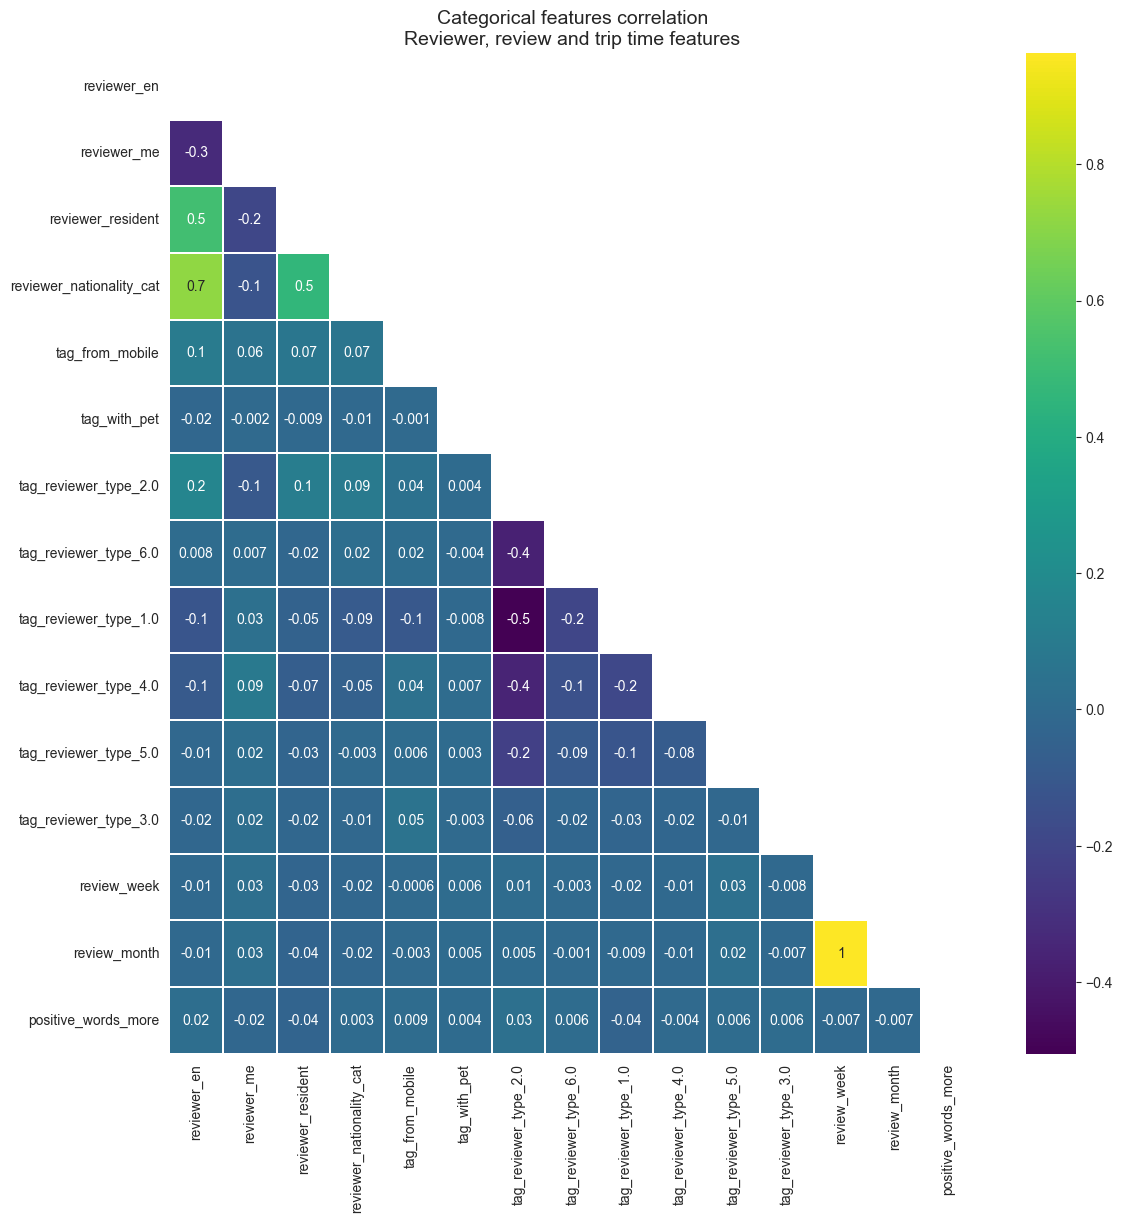

In [258]:
# drawing heatmap for cat 2
show_corr_heatmap(cal_cols_p2, 'Categorical features correlation\nReviewer, review and trip time features',
                  method='spearman', figsize=(13, 13))

In [259]:
# adding some columns with big correlation to drop list
to_drop += ['review_month']

In [261]:
data_copy.drop(to_drop, axis=1, inplace=True)

In [263]:
print(f'Features remaining: {len(data_copy.columns)}')
print('* including "sample" and target metrics')

Features remaining: 45
* including "sample" and target metrics


## Features significance assessment

<AxesSubplot: >

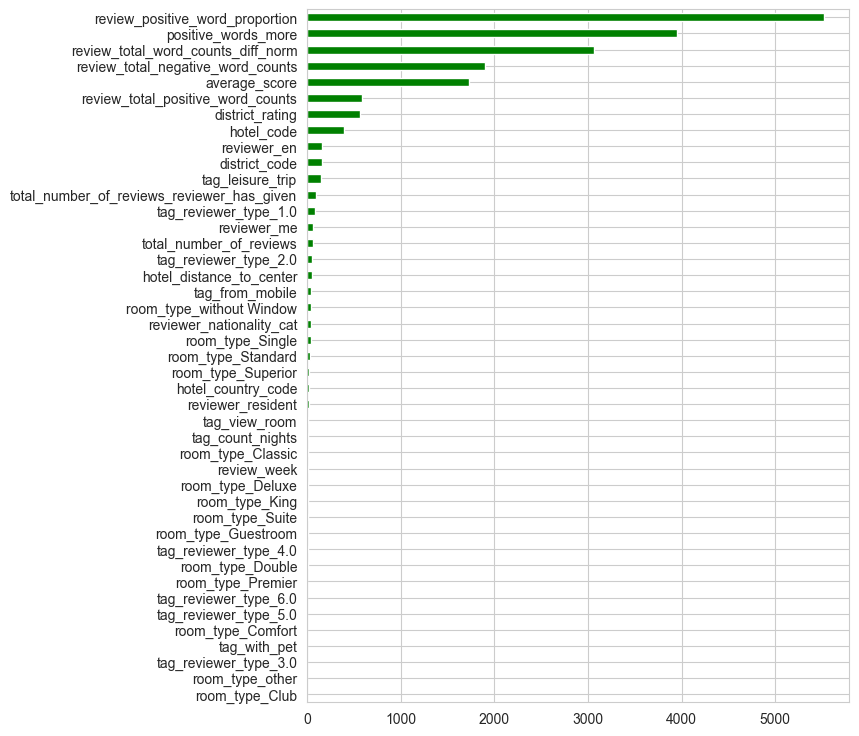

In [293]:
y = data_copy.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# performing ANOVA analisys to check the significance
imp_num = pd.Series(f_classif(X, y)[0], index=X.columns).sort_values()

fig5, ax5 = plt.subplots(figsize=(7, 9))
imp_num.plot(kind='barh', color='green')


In [303]:
# tags starting from tag_view_room do not demonstrate correlation with target score.
# Let's drop them out
to_drop = list(imp_num[:18].index)
data_copy.drop(to_drop, axis=1, inplace=True)

In [304]:
print(f'Features remaining: {len(data_copy.columns)}')
print('* including "sample" and target metrics')

Features remaining: 27
* including "sample" and target metrics


# 3. MODEL BUILDING

In [305]:
# Теперь выделим тестовую часть
train_data = data_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = data_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [306]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [307]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 26), (386803, 26), (386803, 25), (309442, 25), (77361, 25))

In [310]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [311]:
%%time
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   36.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


In [314]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13639409041290287


<AxesSubplot: >

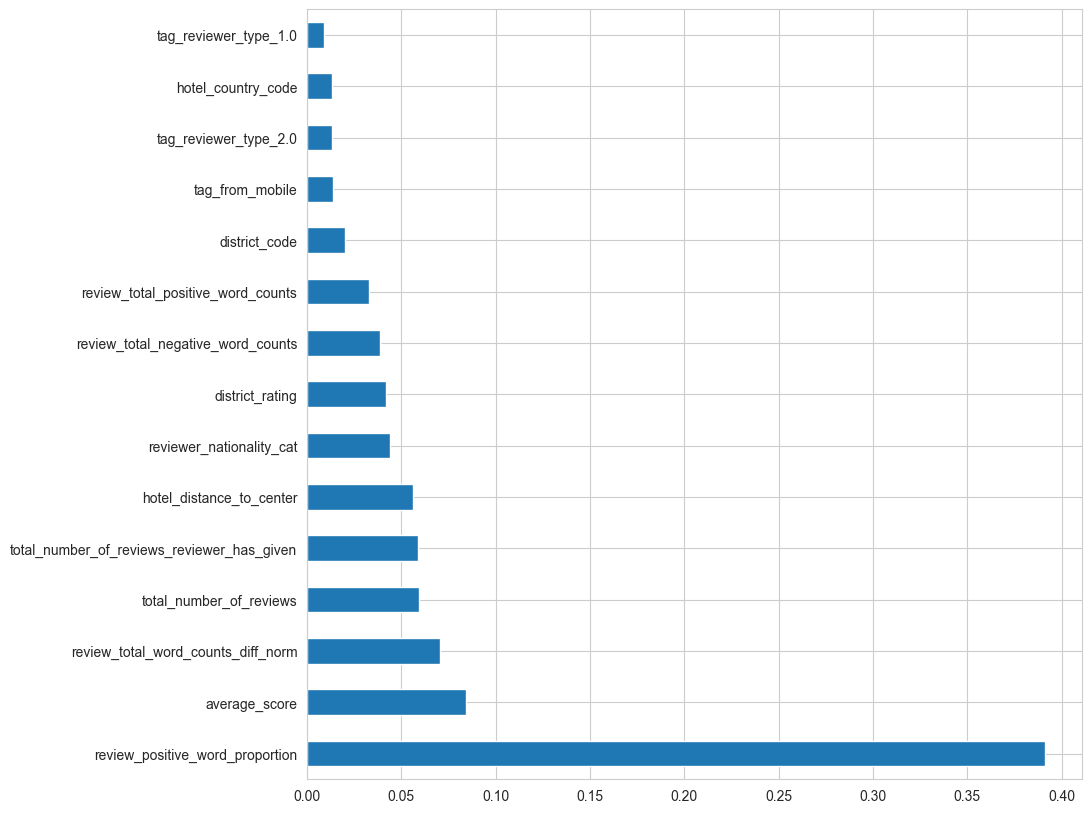

In [315]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [316]:
# getting target score prediction
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

# saving result
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


,reviewer_score,id
0,8.6515,488440
1,7.0280,274649
2,7.2230,374688
3,9.5860,404352
4,9.6730,451596
